# Leonardo Gracida Munoz A01379812
Red neuronal que clasifica 4 tipos de climas, Rainy, Shine, Sunrise y Cloudy <br>
Link hacia el dataset usada:
https://data.mendeley.com/datasets/4drtyfjtfy/1


In [84]:
from google.colab import drive
drive.mount('/content/drive')
!nvidia-smi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Thu Nov 24 00:11:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    34W /  70W |  14632MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+------

Hacemos el unzip del dataset en drive

In [85]:
#Esto lo corremos una vez para poder extraer el zip del dataset en drive
import zipfile
TMP_DATA_DIR = "/content/drive/MyDrive"
"""
#print("Unzipping {} to {}...".format(file, directory))
with zipfile.ZipFile("/content/drive/MyDrive/weather_dataset.zip","r") as zip_ref:
        zip_ref.extractall(TMP_DATA_DIR)"""

'\n#print("Unzipping {} to {}...".format(file, directory))\nwith zipfile.ZipFile("/content/drive/MyDrive/weather_dataset.zip","r") as zip_ref:\n        zip_ref.extractall(TMP_DATA_DIR)'

Vemos el tamaño de una imagen

In [86]:
import cv2
import numpy as np
import pandas as pd
import os
path = "/content/drive/MyDrive/weather_dataset/"
img = cv2.imread("/content/drive/MyDrive/weather_dataset/0/cloudy2.jpg")
print(img.shape)

(300, 400, 3)


Al ver el tamaño, vamos a declarar un tamaño estandar para todas las imagenes, en este caso va a ser (250, 250).

Usaremos dos funciones para hacer data aumentation, una donde se haga una deformación horizontal y otra donde se modifique la iluminación orignal de la imagen, donde se pueda hacer más oscura o brillante de lo que es.

In [87]:
import random

def fill(img, h, w):
    img = cv2.resize(img, (h, w), cv2.INTER_CUBIC)
    return img
        
def horizontal_shift(img, ratio=0.0):
    if ratio > 1 or ratio < 0:
        print('Value should be less than 1 and greater than 0')
        return img
    ratio = random.uniform(-ratio, ratio)
    h, w = img.shape[:2]
    to_shift = w * ratio
    if ratio > 0:
        img = img[:, :int(w - to_shift), :]
    if ratio < 0:
        img = img[:, int(-1 * to_shift):, :]
    img = fill(img, h, w)
    return img

Fncion de preprocesamiento para poder entrenar e ingresar en la red

In [88]:
def preprocess(img,imgDimensions):
    img = cv2.resize(img,imgDimensions)
    img = img/255
    return img

Como toda la dataset no esta separada en train y test, lo que vamos a hacer es separar las imagenes en dos arreglos uno de train y otro de test y los vamos a guardar en un folder, como a la vez separar cada categoría en un folder diferente dentro de los folders de train y test.

In [89]:
"""
images = []
labels = []
for i in os.listdir(path):
    print(i)
    for j in os.listdir(os.path.join(path,i)):
        try:
            img = cv2.imread(os.path.join(path,i,j))
            img2 = horizontal_shift(img,0.1)
            #img2 = brightness(img2,0.8,1)
            #print(img.shape)
            img = preprocess(img,(250,250))
            img2 = preprocess(img2,(250,250))
            images.append(img)
            labels.append(int(i))
            images.append(img2)
            labels.append(int(i))
        except:
            print(os.path.join(path,i,j))"""

'\nimages = []\nlabels = []\nfor i in os.listdir(path):\n    print(i)\n    for j in os.listdir(os.path.join(path,i)):\n        try:\n            img = cv2.imread(os.path.join(path,i,j))\n            img2 = horizontal_shift(img,0.1)\n            #img2 = brightness(img2,0.8,1)\n            #print(img.shape)\n            img = preprocess(img,(250,250))\n            img2 = preprocess(img2,(250,250))\n            images.append(img)\n            labels.append(int(i))\n            images.append(img2)\n            labels.append(int(i))\n        except:\n            print(os.path.join(path,i,j))'

In [90]:
"""
images = np.array(images)
labels = np.array(labels)
print(images.shape)"""

'\nimages = np.array(images)\nlabels = np.array(labels)\nprint(images.shape)'

Creamos el modelo

In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import BinaryAccuracy, FalseNegatives, AUC
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
import tensorflow as tf
def prepare_model():
    model = Sequential()
    model.add(Conv2D(120,kernel_size=(3,3),activation='relu',input_shape=(250, 250, 3)))
    model.add(Conv2D(120,kernel_size=(3,3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(60,kernel_size=(2,2),activation='relu'))
    model.add(Conv2D(60,kernel_size=(2,2),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(30,kernel_size=(2,2),activation='relu'))
    model.add(Conv2D(30,kernel_size=(2,2),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15,kernel_size=(2,2),activation='relu'))
    model.add(Conv2D(15,kernel_size=(2,2),activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Flatten())
    model.add(Dense(2000, activation='relu'))
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001),                                                                                                                                                                       loss=BinaryCrossentropy(),                                                                                                                                                                         
              metrics=[ "acc",AUC()]) 
    return model

In [92]:
model = prepare_model()

In [93]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 248, 248, 120)     3360      
                                                                 
 conv2d_33 (Conv2D)          (None, 246, 246, 120)     129720    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 123, 123, 120)    0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 122, 122, 60)      28860     
                                                                 
 conv2d_35 (Conv2D)          (None, 121, 121, 60)      14460     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 60, 60, 60)       0         
 g2D)                                                 

Separamos el modelo en train y test

In [94]:
"""
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2,stratify = labels)
del(images)
del(labels)"""

'\nfrom sklearn.model_selection import train_test_split\nX_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2,stratify = labels)\ndel(images)\ndel(labels)'

In [95]:
"""
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
print("Labels en modo categorical")
print(y_train.shape)
print(y_test.shape)
#print(y_val.shape)
classTotal = y_train.sum(axis=0)
classWeight = classTotal.max() / classTotal
print("Proporcion de cada tipo de muestra en el dateset usado:")
print(classWeight)
#classWeight = {i: classWeight[i] for i in range(len(classWeight))}"""

'\ny_train = tf.keras.utils.to_categorical(y_train)\ny_test = tf.keras.utils.to_categorical(y_test)\nprint("Labels en modo categorical")\nprint(y_train.shape)\nprint(y_test.shape)\n#print(y_val.shape)\nclassTotal = y_train.sum(axis=0)\nclassWeight = classTotal.max() / classTotal\nprint("Proporcion de cada tipo de muestra en el dateset usado:")\nprint(classWeight)\n#classWeight = {i: classWeight[i] for i in range(len(classWeight))}'

Ahora guardamos el train y test en folders diferentes y esto solo lo hacemos una vez, al ya tenerlos separados podemos llamar las imagenes por medio de lotes en lugar de guardas todas en la memoria RAM a la vez.

In [100]:
path_sorted = "/content/drive/MyDrive/weather_dataset_separated"
counter = 0
"""
for i,j in zip(X_train,y_train):
    name = os.path.join(path_sorted,"train",str(j),"img_"+str(counter)+".jpg")
    #print(name)
    cv2.imwrite(name,i)
    counter += 1"""
"""
for i,j in zip(X_test,y_test):
    name = os.path.join(path_sorted,"test",str(j),"img_"+str(counter)+".jpg")
    #print(name)
    cv2.imwrite(name,i)
    counter += 1"""

'\nfor i,j in zip(X_test,y_test):\n    name = os.path.join(path_sorted,"test",str(j),"img_"+str(counter)+".jpg")\n    #print(name)\n    cv2.imwrite(name,i)\n    counter += 1'

Creamos el data generator para train y test.

In [101]:
image_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        validation_split=0.20
)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

Creamos el flow para train, test y validation

In [102]:
batch_size = 16
print("Train:")
train_generator = image_datagen.flow_from_directory(
    directory=os.path.join(path_sorted,"train"),
    target_size=(250, 250),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)
print("Validation:")
valid_generator = image_datagen.flow_from_directory(
    directory=os.path.join(path_sorted,"train"),
    target_size=(250, 250),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation',
    shuffle=True,
    seed=42
)
print("Test:")
test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(path_sorted,"test"),
    target_size=(250, 250),
    color_mode="rgb",
    batch_size=128,
    class_mode=None,
    shuffle=False,
    seed=42
)

Train:
Found 1438 images belonging to 4 classes.
Validation:
Found 358 images belonging to 4 classes.
Test:
Found 450 images belonging to 4 classes.


Entrenamos el modelo

In [103]:
from tensorflow.keras.callbacks import EarlyStopping

with tf.device('/device:GPU:0'):
    monitor_val_acc=EarlyStopping(monitor = 'val_loss', patience=2)
    H = model.fit(train_generator,validation_data = valid_generator,epochs=25,steps_per_epoch = train_generator.n//train_generator.batch_size,validation_steps = valid_generator.n//valid_generator.batch_size,
              callbacks = [monitor_val_acc])

Epoch 1/25
89/89 [==============================] - 26s 287ms/step - loss: 0.3412 - acc: 0.6231 - auc_4: 0.8828 - val_loss: 0.2371 - val_acc: 0.8011 - val_auc_4: 0.9518
Epoch 2/25
89/89 [==============================] - 25s 280ms/step - loss: 0.2436 - acc: 0.7834 - auc_4: 0.9461 - val_loss: 0.2139 - val_acc: 0.8153 - val_auc_4: 0.9610
Epoch 3/25
89/89 [==============================] - 25s 284ms/step - loss: 0.2038 - acc: 0.8179 - auc_4: 0.9607 - val_loss: 0.2315 - val_acc: 0.7898 - val_auc_4: 0.9550
Epoch 4/25
89/89 [==============================] - 25s 276ms/step - loss: 0.1727 - acc: 0.8474 - auc_4: 0.9713 - val_loss: 0.1825 - val_acc: 0.8352 - val_auc_4: 0.9638
Epoch 5/25
89/89 [==============================] - 25s 278ms/step - loss: 0.1560 - acc: 0.8755 - auc_4: 0.9736 - val_loss: 0.1634 - val_acc: 0.8608 - val_auc_4: 0.9725
Epoch 6/25
89/89 [==============================] - 25s 275ms/step - loss: 0.1395 - acc: 0.8819 - auc_4: 0.9796 - val_loss: 0.2590 - val_acc: 0.8295 - val_

Guardamos el modelo

In [104]:
model.save("/content/drive/MyDrive/weather_model1")

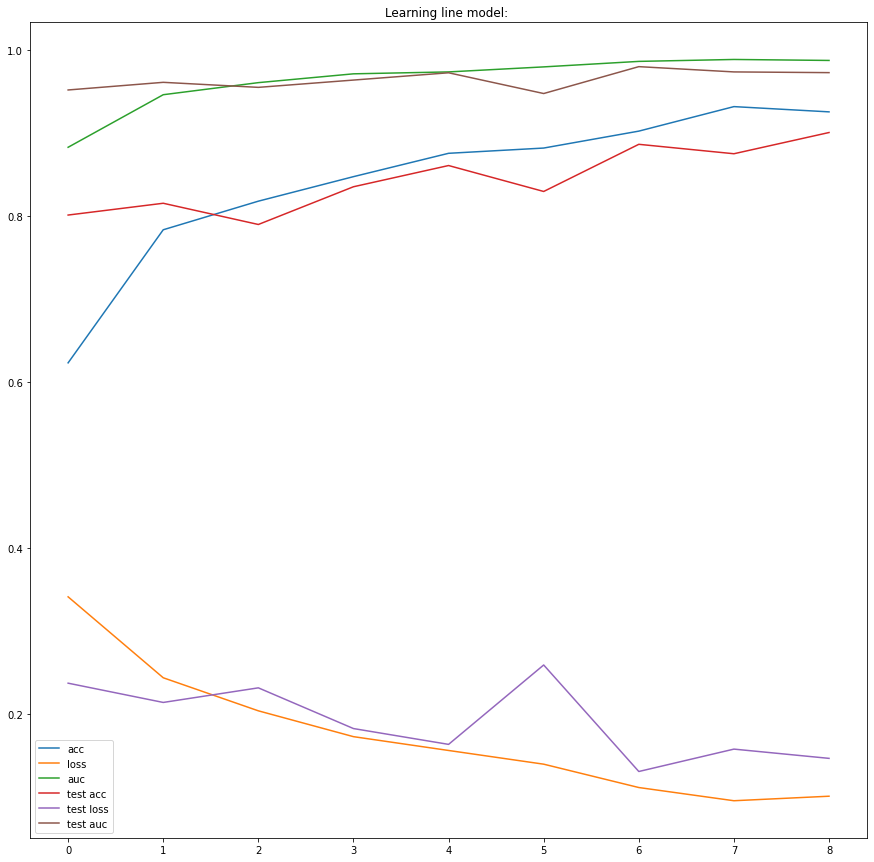

In [107]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 15))
plt.plot(H.history["acc"])
plt.plot(H.history["loss"])
plt.plot(H.history["auc_4"])
plt.plot(H.history["val_acc"])
plt.plot(H.history["val_loss"])
plt.plot(H.history["val_auc_4"])
plt.title("Learning line model: ")
plt.legend(["acc",  "loss", "auc", "test acc","test loss", "test auc"])

Al ver la curva de aprendizaje vemos que no es inestable, al ver que converge y no tiene picos extremos y constantes.

In [108]:
from google.colab.patches import cv2_imshow
weat = {0:"cloudy",1:"rainy",2:"sunrise",3:"shine"}

Evaluamos el modelo con la parte de validacion

In [109]:
with tf.device('/device:GPU:0'):
    score = model.evaluate(valid_generator)

23/23 [==============================] - 3s 147ms/step - loss: 0.1461 - acc: 0.8994 - auc_4: 0.9730


In [110]:
print('val loss:', score[0])
print('val accuracy:', score[1])

val loss: 0.1460845172405243
val accuracy: 0.8994413614273071


Hacemos una prediccion al azar en el folder de test

In [111]:
img_size = (250,250)
def pred_img(img,img_size,model):
    cv2_imshow(img)
    img = preprocess(img,img_size)
    img = np.expand_dims(img,axis=0)
    pred = model.predict(img)
    max = np.argmax(pred)
    prob = np.round(pred[0][max]*100,2)
    print(weat[max],prob)

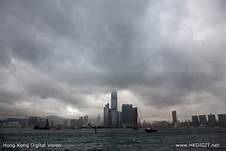

1/1 [==============================] - 0s 99ms/step
cloudy 99.9


In [112]:
img = cv2.imread("/content/drive/MyDrive/weather_dataset_separated/test/0/img_210.jpg")
pred_img(img,img_size,model)

Hacemos todas las predicciones de la parte de test

In [113]:
with tf.device('/device:GPU:0'):
    predict = model.predict(test_generator)

4/4 [==============================] - 3s 905ms/step


Obtenemos las inferencias obtenidas del test

In [114]:
pred_classes = predict.argmax(axis=-1)

Labels reales

In [115]:
print(pred_classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0 3 0 0 3 0 2 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0
 1 1 0 0 0 0 2 0 0 0 0 0 1 0 0 0 2 2 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 2 0 0 1 3 0 1 1 1 1 2 1 0 3 1 0 1 3 1 1 1
 1 0 1 1 1 1 3 0 1 0 0 1 0 1 0 0 1 1 1 1 1 2 1 3 1 1 1 1 1 0 1 0 1 1 1 1 0
 0 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 3 1 1 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2
 2 2 2 2 2 2 0 2 2 2 0 2 2 2 2 2 2 2 0 2 2 2 2 2 2 0 2 2 2 2 0 2 2 2 2 2 2
 2 2 2 2 2 0 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3]


Inferencias del test

In [116]:
print(test_generator.classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3]


Precision del modelo en el test

In [117]:
from sklearn.metrics import accuracy_score
accuracy_score(test_generator.classes,pred_classes)

0.8688888888888889

Ahora lo que vamos a hacer es mejorar nuestro modelo

In [118]:
def prepare_model():
    model = Sequential()
    model.add(Conv2D(120,kernel_size=(3,3),activation='relu',input_shape=(250, 250, 3)))
    model.add(Conv2D(120,kernel_size=(3,3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(60,kernel_size=(2,2),activation='relu'))
    model.add(Conv2D(60,kernel_size=(2,2),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(30,kernel_size=(2,2),activation='relu'))
    model.add(Conv2D(30,kernel_size=(2,2),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15,kernel_size=(2,2),activation='relu'))
    model.add(Conv2D(15,kernel_size=(2,2),activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(2000, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),                                                                                                                                                                       loss=BinaryCrossentropy(),                                                                                                                                                                         
              metrics=[ "acc",AUC()]) 
    return model

Lo que hicimos fue agregar parametros en contra del overfitting que es el dropout, como tambien reducir el learning rate, como también el agregar más parámetros al optimzador Adam.

In [119]:
model = prepare_model()

In [120]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 248, 248, 120)     3360      
                                                                 
 conv2d_41 (Conv2D)          (None, 246, 246, 120)     129720    
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 123, 123, 120)    0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 122, 122, 60)      28860     
                                                                 
 conv2d_43 (Conv2D)          (None, 121, 121, 60)      14460     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 60, 60, 60)       0         
 g2D)                                                 

Entrenamos el modelo

In [121]:
with tf.device('/device:GPU:0'):
    monitor_val_acc=EarlyStopping(monitor = 'val_loss', patience=2)
    H = model.fit(train_generator,validation_data = valid_generator,epochs=17,steps_per_epoch = train_generator.n//train_generator.batch_size,validation_steps = valid_generator.n//valid_generator.batch_size)

Epoch 1/17
89/89 [==============================] - 28s 297ms/step - loss: 0.4177 - acc: 0.4923 - auc_5: 0.7986 - val_loss: 0.3414 - val_acc: 0.6023 - val_auc_5: 0.8780
Epoch 2/17
89/89 [==============================] - 25s 279ms/step - loss: 0.2816 - acc: 0.7257 - auc_5: 0.9282 - val_loss: 0.2434 - val_acc: 0.7614 - val_auc_5: 0.9451
Epoch 3/17
89/89 [==============================] - 25s 283ms/step - loss: 0.2413 - acc: 0.7581 - auc_5: 0.9455 - val_loss: 0.2474 - val_acc: 0.7670 - val_auc_5: 0.9461
Epoch 4/17
89/89 [==============================] - 25s 279ms/step - loss: 0.2283 - acc: 0.7940 - auc_5: 0.9536 - val_loss: 0.1957 - val_acc: 0.8068 - val_auc_5: 0.9651
Epoch 5/17
89/89 [==============================] - 25s 274ms/step - loss: 0.2057 - acc: 0.8242 - auc_5: 0.9621 - val_loss: 0.1953 - val_acc: 0.8409 - val_auc_5: 0.9591
Epoch 6/17
89/89 [==============================] - 24s 275ms/step - loss: 0.1815 - acc: 0.8530 - auc_5: 0.9687 - val_loss: 0.2260 - val_acc: 0.7841 - val_

Al ver el entrenamiento vemos que tenemos mejores metricas resultantes, tanto en la accuracy como en el AUC.

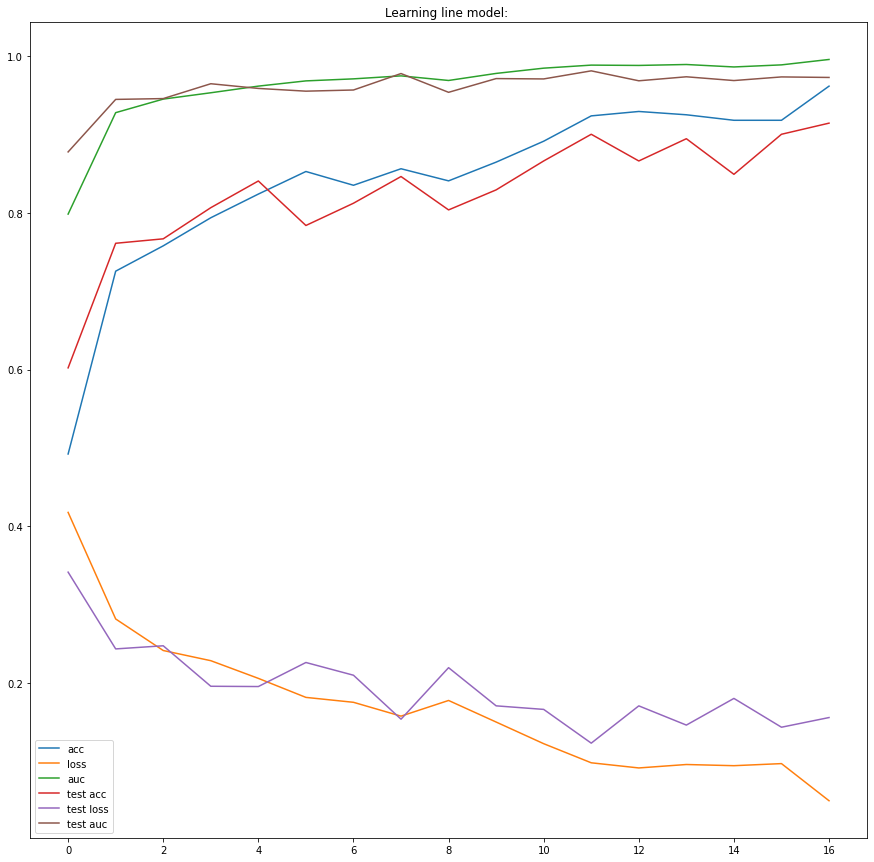

In [122]:
fig = plt.figure(figsize=(15, 15))
plt.plot(H.history["acc"])
plt.plot(H.history["loss"])
plt.plot(H.history["auc_5"])
plt.plot(H.history["val_acc"])
plt.plot(H.history["val_loss"])
plt.plot(H.history["val_auc_5"])
plt.title("Learning line model: ")
plt.legend(["acc",  "loss", "auc", "test acc","test loss", "test auc"])

Tambien vemos que la linea de aprendizaje no es inestable, ya que no tiene picos extraños

In [123]:
with tf.device('/device:GPU:0'):
    score = model.evaluate(valid_generator)

23/23 [==============================] - 3s 148ms/step - loss: 0.1548 - acc: 0.9162 - auc_5: 0.9734


In [124]:
print('val loss:', score[0])
print('val accuracy:', score[1])

val loss: 0.1548166275024414
val accuracy: 0.916201114654541


Tambien vemos que tiene una mejor presición en la parte de la validacion

Hacemos la misma prediccion

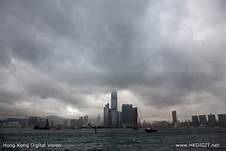

1/1 [==============================] - 0s 118ms/step
cloudy 82.3


In [125]:
img = cv2.imread("/content/drive/MyDrive/weather_dataset_separated/test/0/img_210.jpg")
pred_img(img,img_size,model)

Volvemos a predecir todas las imagenes de test

In [126]:
with tf.device('/device:GPU:0'):
    predict = model.predict(test_generator)

4/4 [==============================] - 3s 906ms/step


In [127]:
pred_classes = predict.argmax(axis=-1)

In [128]:
print("Labels reales:")
print(pred_classes)

Labels reales:
[0 0 0 0 0 0 0 1 0 2 2 0 0 0 1 2 0 2 0 0 0 0 0 0 0 0 0 0 0 3 0 0 3 0 2 0 0
 0 0 0 0 0 0 0 0 0 1 2 0 0 0 1 2 0 0 0 2 0 0 0 0 0 0 0 0 0 1 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 1 0 0 0 0 2 2 1 0 0 0 1 0 0 0 0
 0 2 1 0 0 0 2 0 0 1 1 1 1 1 1 1 2 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0
 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3]


In [129]:
print("Labels predicciones:")
print(test_generator.classes)

Labels predicciones:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3]


In [130]:
from sklearn.metrics import accuracy_score
print("Accuracy en el test: ",accuracy_score(test_generator.classes,pred_classes))

Accuracy en el test:  0.9177777777777778


Vemos que tenemos una notable mejoría en la acc de test en comparación con el modelo anterior

In [ ]:
model.save("/content/drive/MyDrive/weather_model2")

Hacemos unas predicciones con imagenes random de internet

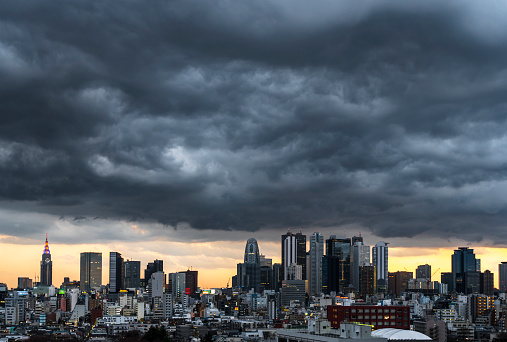

1/1 [==============================] - 0s 27ms/step
cloudy 99.95


In [132]:
img = cv2.imread("cloudy.jpg")
pred_img(img,img_size,model)

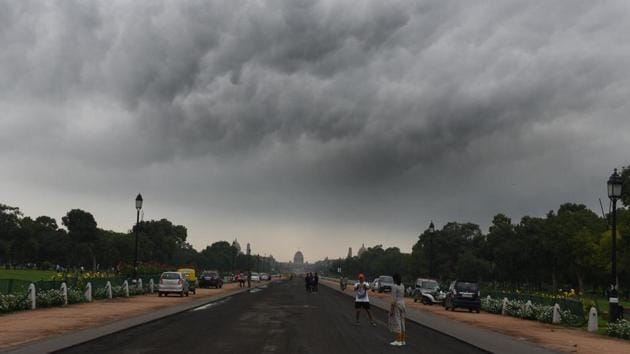

1/1 [==============================] - 0s 70ms/step
cloudy 99.9


In [134]:
img = cv2.imread("cloudy2.jpg")
pred_img(img,img_size,model)

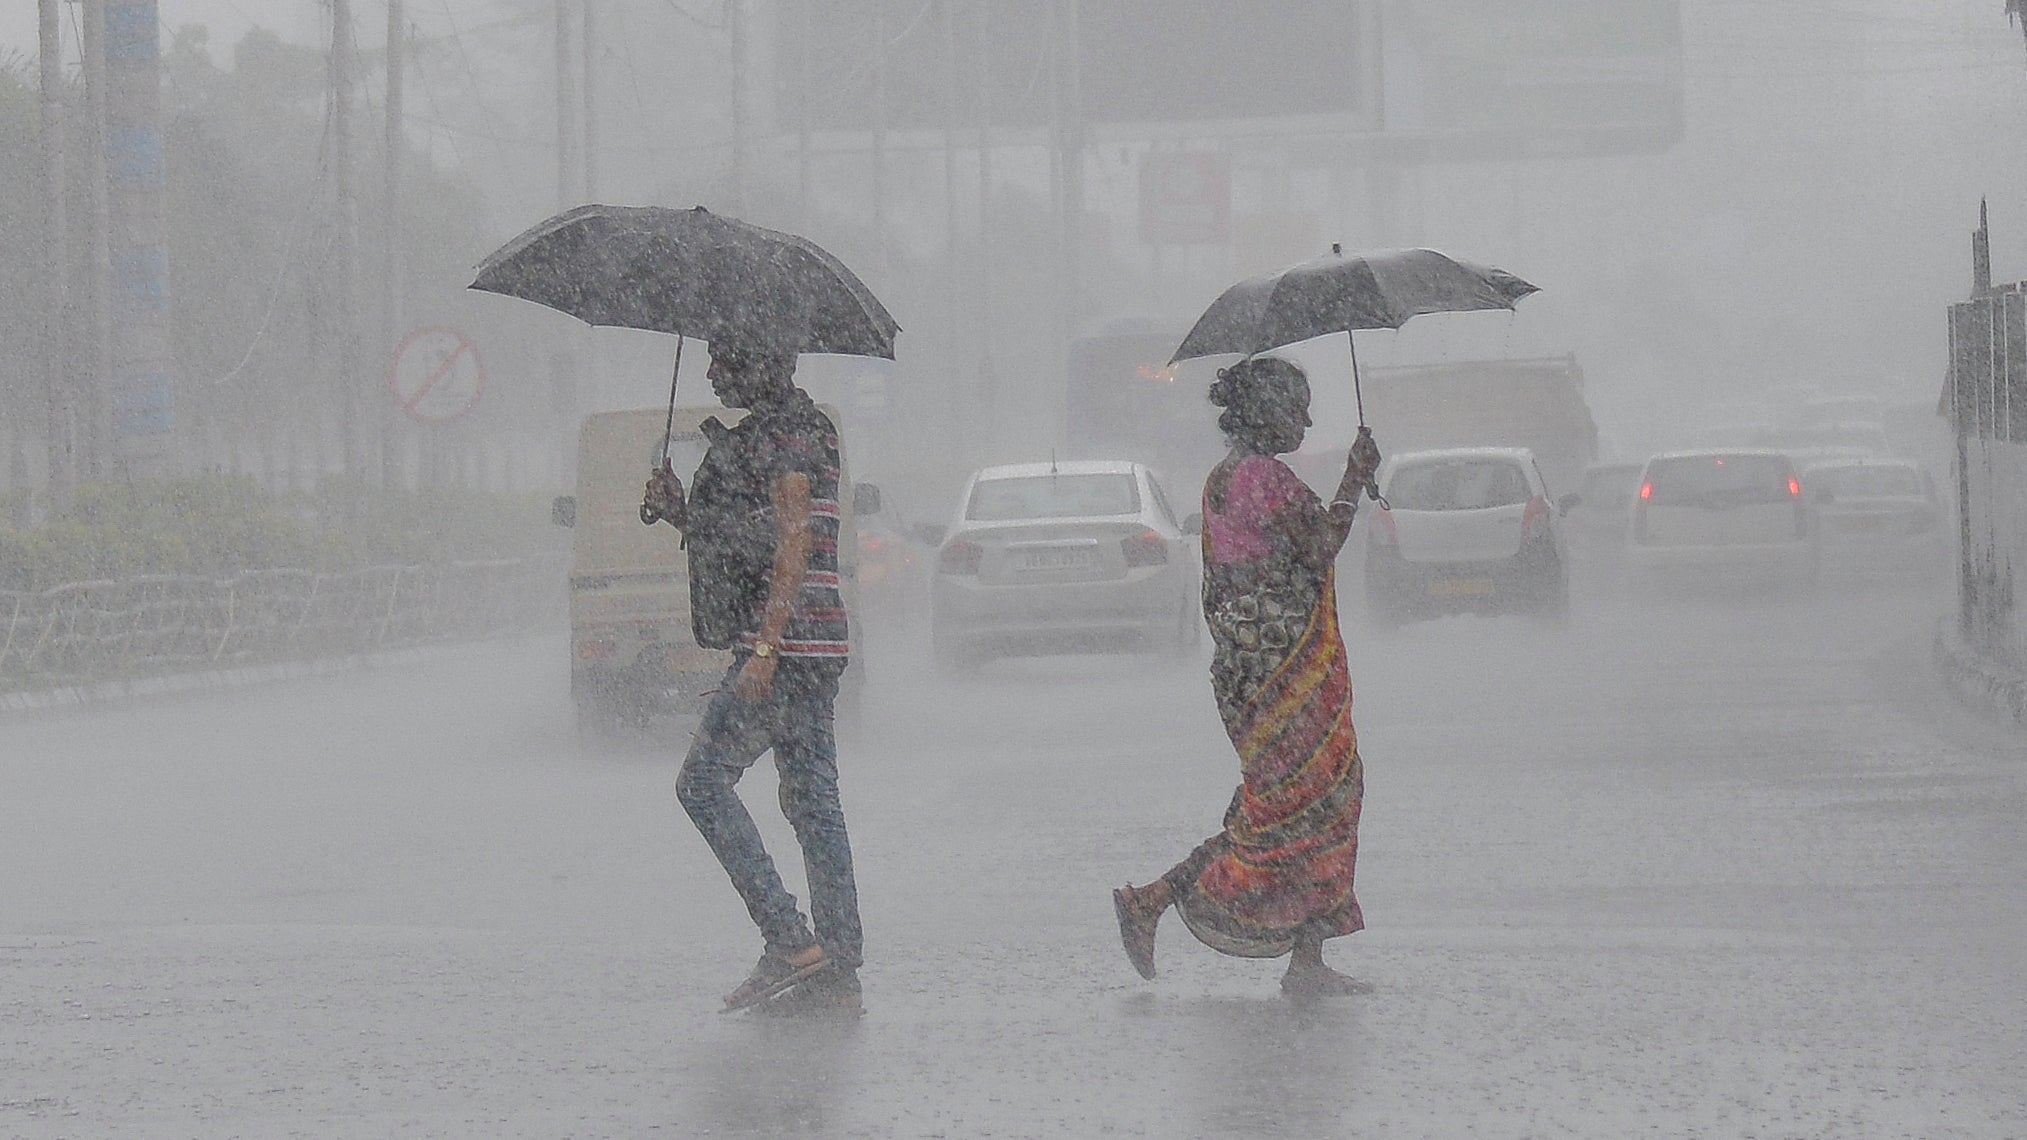

1/1 [==============================] - 0s 34ms/step
rainy 90.9


In [135]:
img = cv2.imread("lluvia.jpg")
pred_img(img,img_size,model)

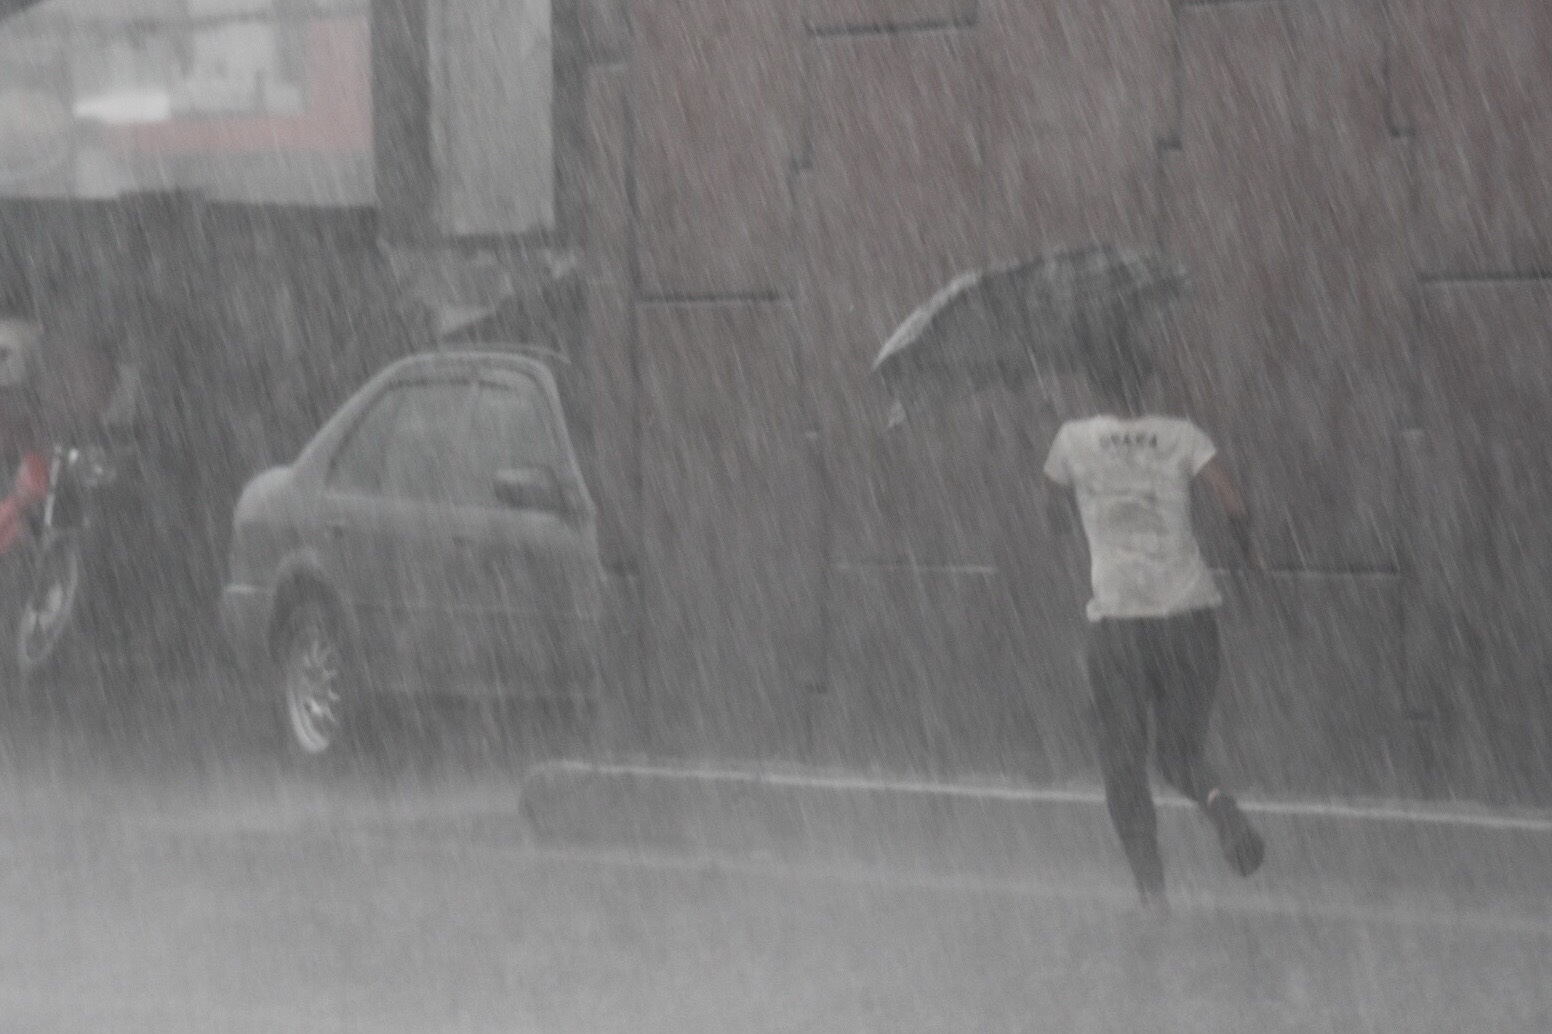

1/1 [==============================] - 0s 26ms/step
rainy 83.29


In [137]:
img = cv2.imread("lluvia2.jpg")
pred_img(img,img_size,model)

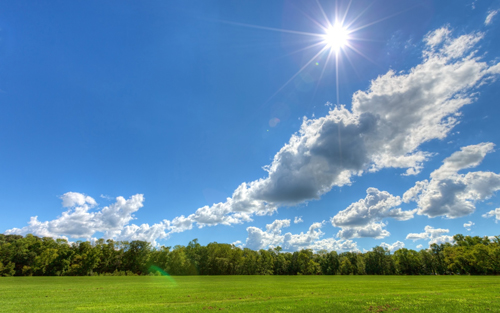

1/1 [==============================] - 0s 27ms/step
shine 100.0


In [138]:
img = cv2.imread("shine.jpg")
cv2_imshow(img)
img = preprocess(img,(250,250))
img = np.expand_dims(img,axis=0)
pred = model.predict(img)
max = np.argmax(pred)
prob = np.round(pred[0][max]*100,2)
print(weat[max],prob)

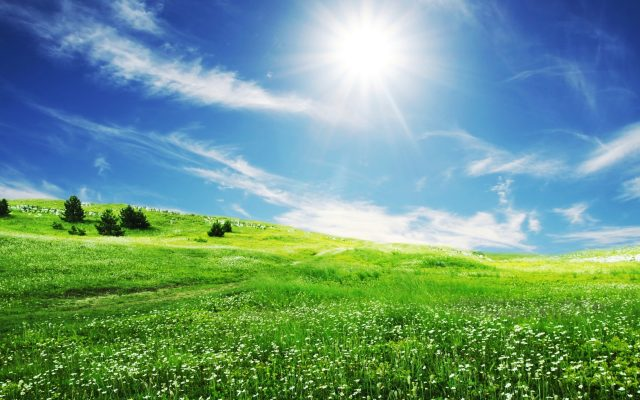

1/1 [==============================] - 0s 24ms/step
shine 100.0


In [140]:
img = cv2.imread("shine2.jpeg")
pred_img(img,img_size,model)

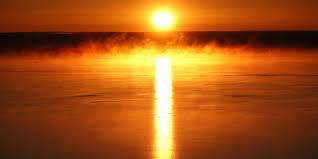

1/1 [==============================] - 0s 25ms/step
sunrise 100.0


In [143]:
img = cv2.imread("sunrise.jpg")
pred_img(img,img_size,model)

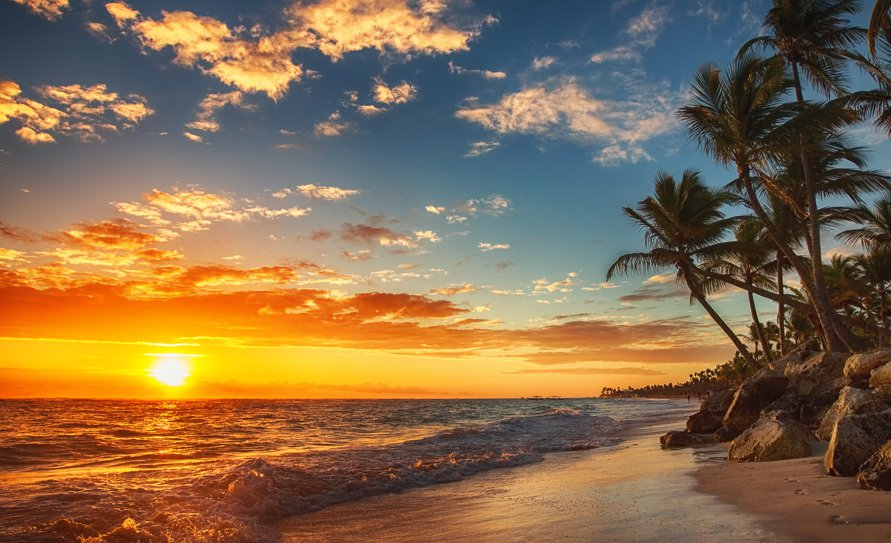

1/1 [==============================] - 0s 28ms/step
sunrise 100.0


In [144]:
img = cv2.imread("sunrise2.jpg")
pred_img(img,img_size,model)

Vemos que logramos hacer buenas inferencias con estas imagenes de internet.